### Imports

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import math

# Find best image differencing parameters.

In [2]:
im1 = imread('./data/aerobic-001.bmp')
im1 = img_as_float(im1)
im2 = imread('./data/aerobic-002.bmp')
im2 = img_as_float(im2)

## Simple Image Difference

For sake of simplicity of implementation, we shall use the naive differencing function, as given as below instead of using Weber's difference.

$\Delta I = 1 \text{ if } |I_t - I_{t-1}| > \tau$

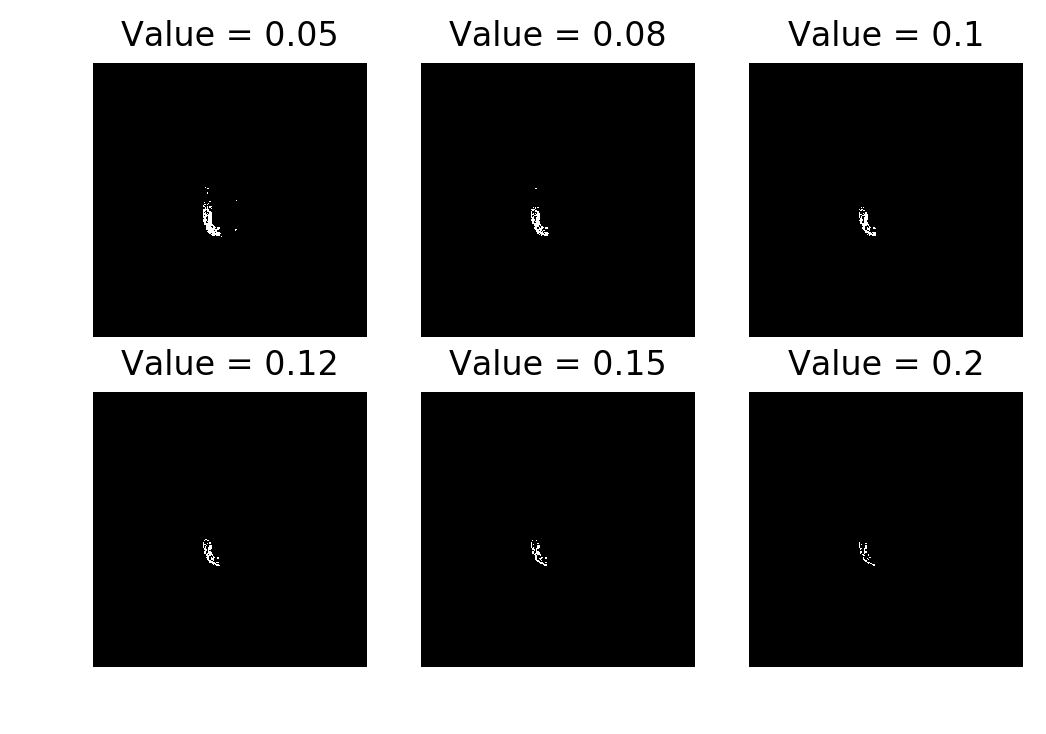

In [3]:
threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

Notice that by default, the thresholding generates a fractured image, which is not ideal for motion analysis.  This can be fixed by using morphological operators as discussed below.

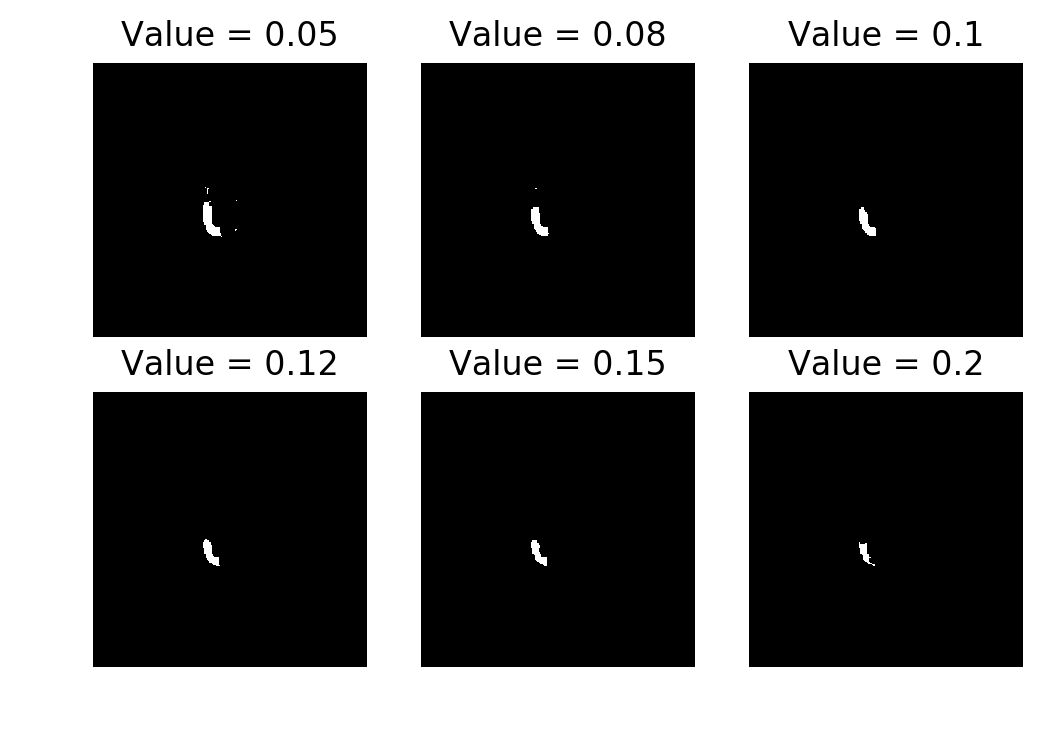

In [4]:
from skimage.morphology import closing
from skimage.morphology import square

threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    magIm = closing(magIm, square(5))
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')


The results upon using closing, I found generates the best result. But I have also included other operations for sake of comparision.

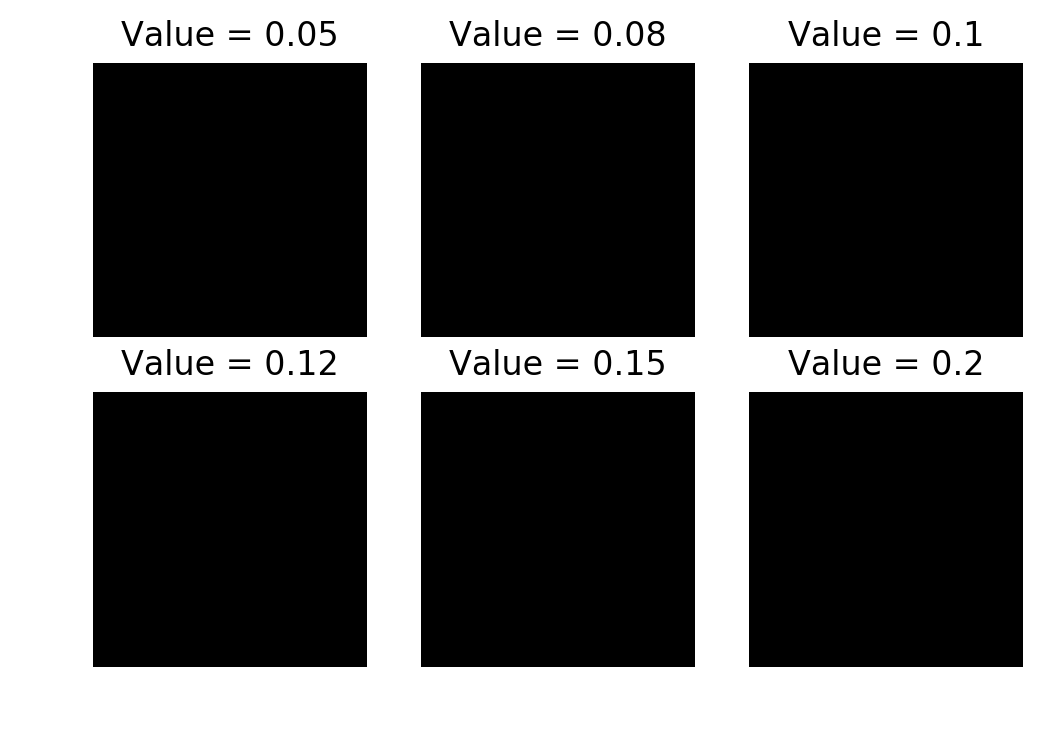

In [5]:
from skimage.morphology import opening
threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    magIm = opening(magIm, square(5))
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

Opening fails because it erodes first causing our fractured image to vanish.

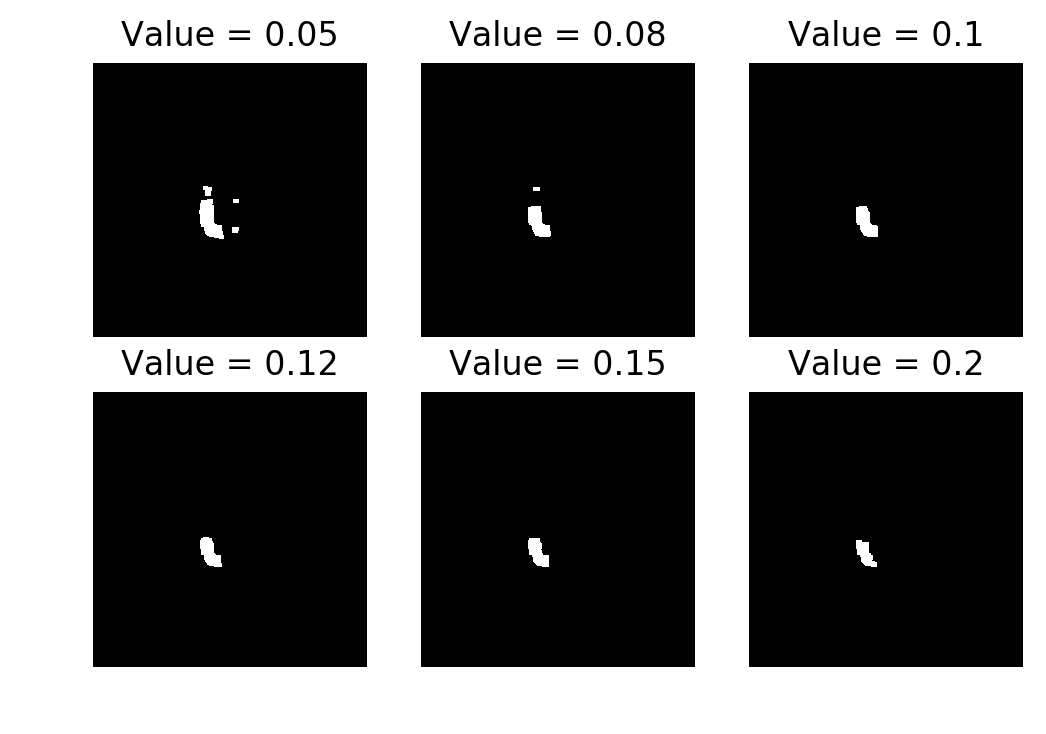

In [6]:
from skimage.morphology import dilation
threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    magIm = dilation(magIm, square(5))
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

While dilation generates a good result, the chunkyness could lead to false positives for motion detectors

/usr/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


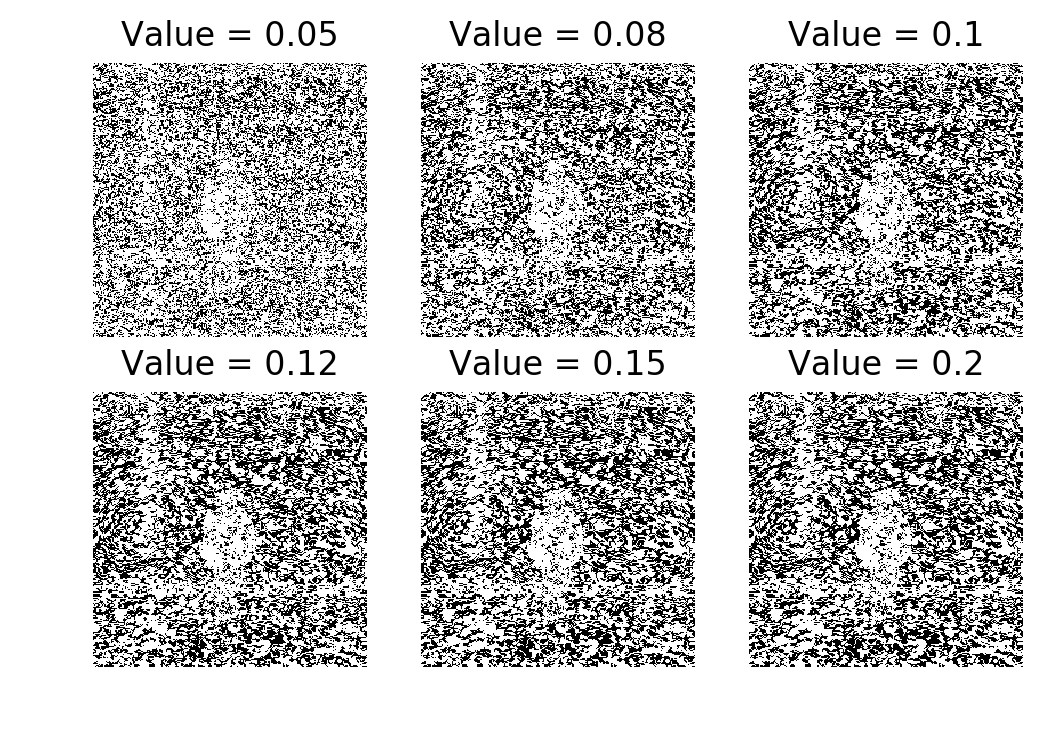

In [7]:
from skimage.filters.rank import median

threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    im1 = median(im1)
    im2 = median(im2)
    magIm = np.abs(im1 - im2)
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

I'm not sure if this is an implementation fault, or the result of sharpening an image with a lot of information, whatever be the case, the image generated cannot be used for upcoming exercise.

# Perform Motion History Imaging and Motion Energy Imaging using the best differencing technique

In [8]:
aer_cube = []

for i in range(1,23):
    tmp = imread('./data/aerobic-{:03}.bmp'.format(i))
    tmp = img_as_float(tmp)
    aer_cube.append(tmp)
    
aer_cube=np.array(aer_cube)

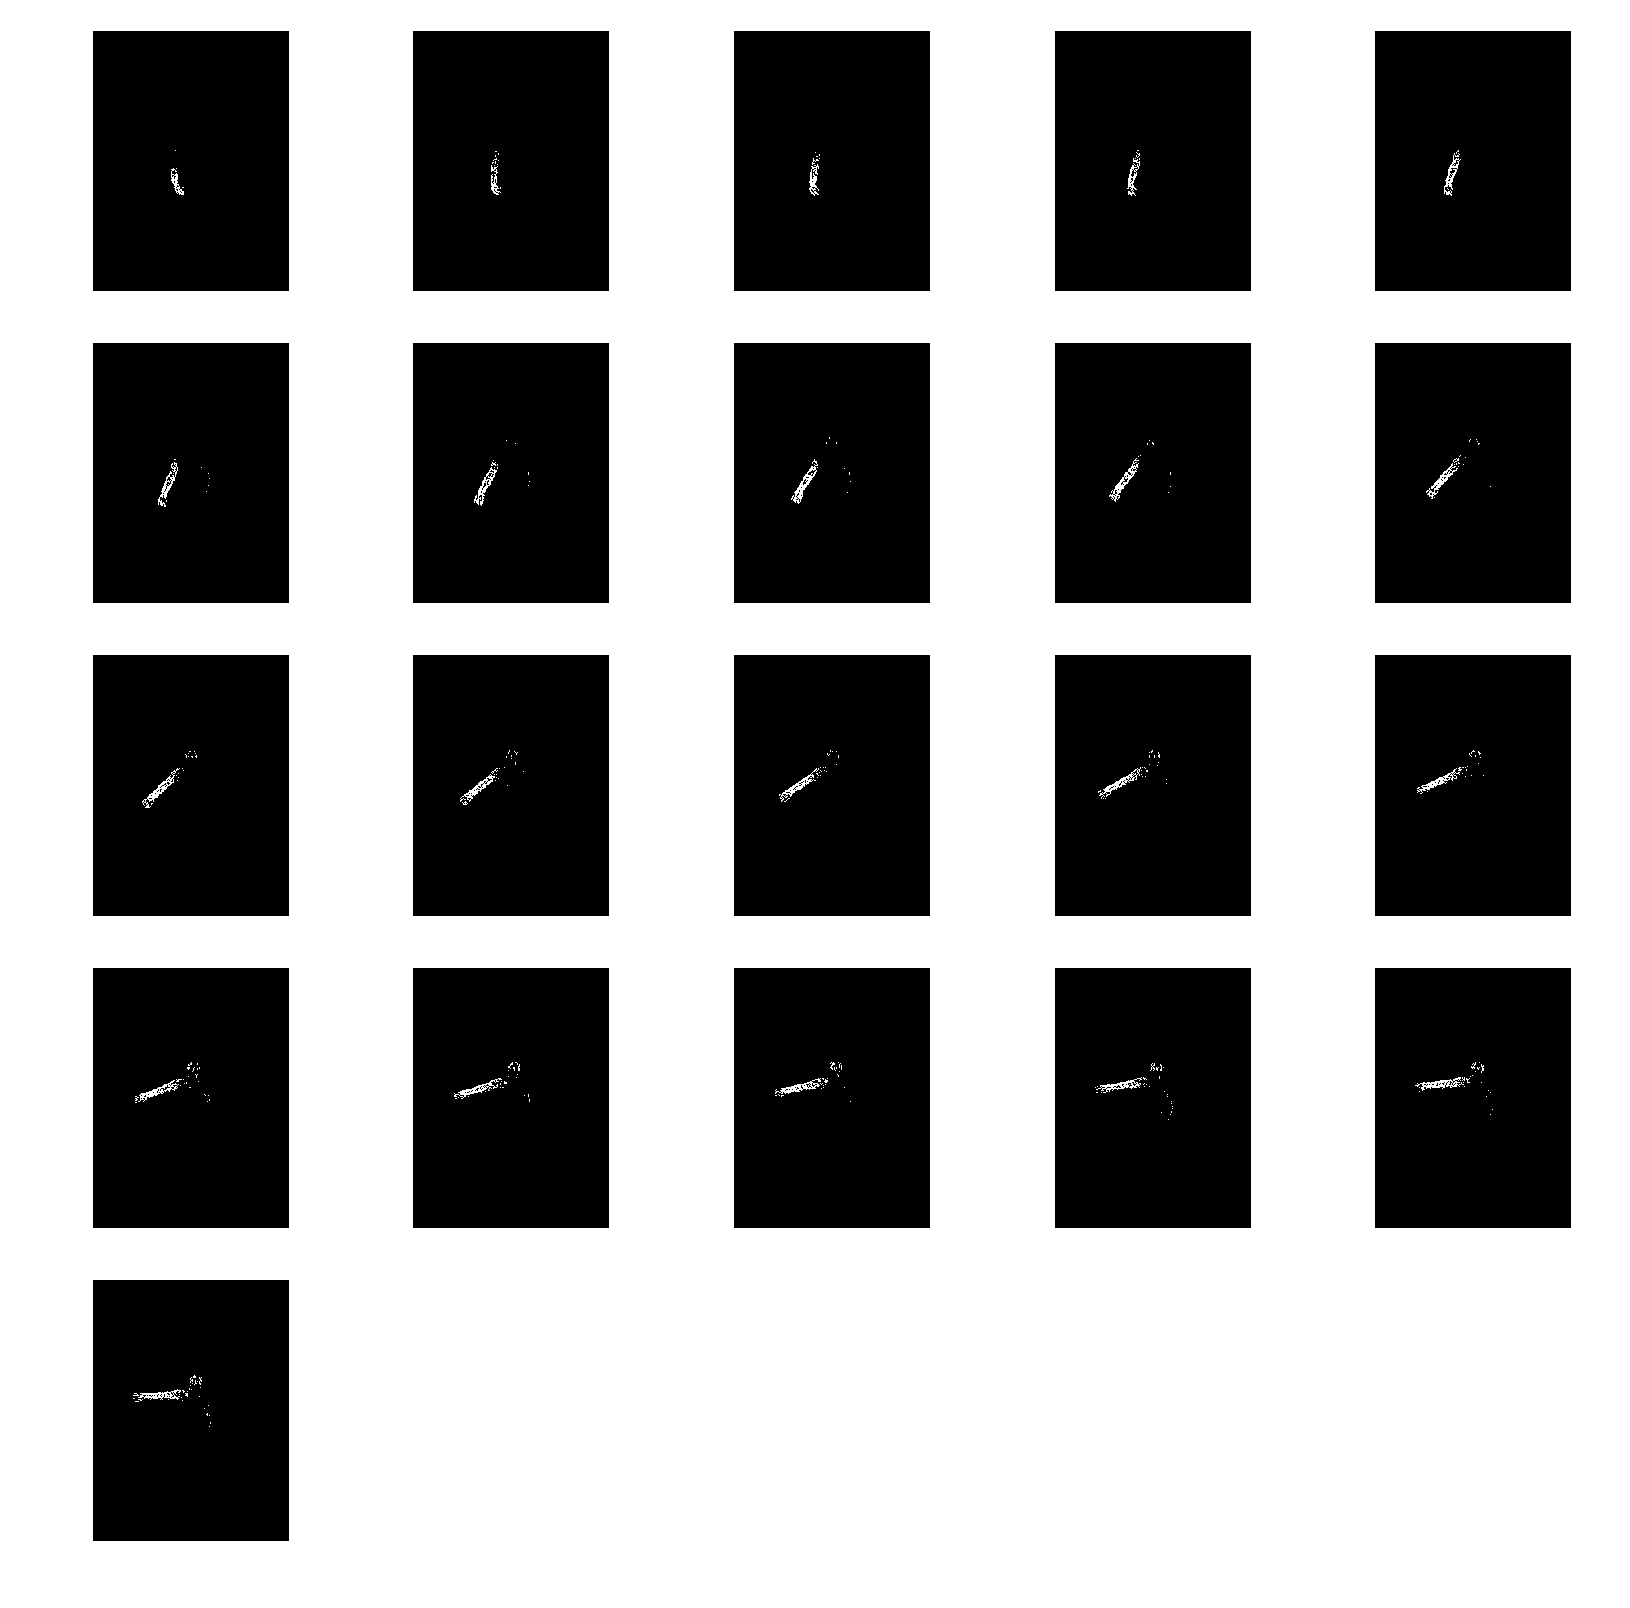

In [9]:
f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(np.abs(aer_cube[idx]-aer_cube[idx+1]) > 0.08, cmap = 'gray')
    
for idx in range(21, 25):
    axarr[idx//5, idx%5].axis('off')

Just a plot of consecutive image differences.

In [10]:
aer_cube.shape

aer_cube[0].max()

T = aer_cube.shape[0]

In [11]:
aer_diff = np.abs(aer_cube[1:,:,:] - aer_cube[:-1,:,:])

for i in range(aer_diff.shape[0]):
    aer_diff[i] = closing(aer_diff[i], square(5)) > 0.08

In [12]:
MEI = [aer_diff[:i, :, :].max(axis=0) for i in range(1, T)]

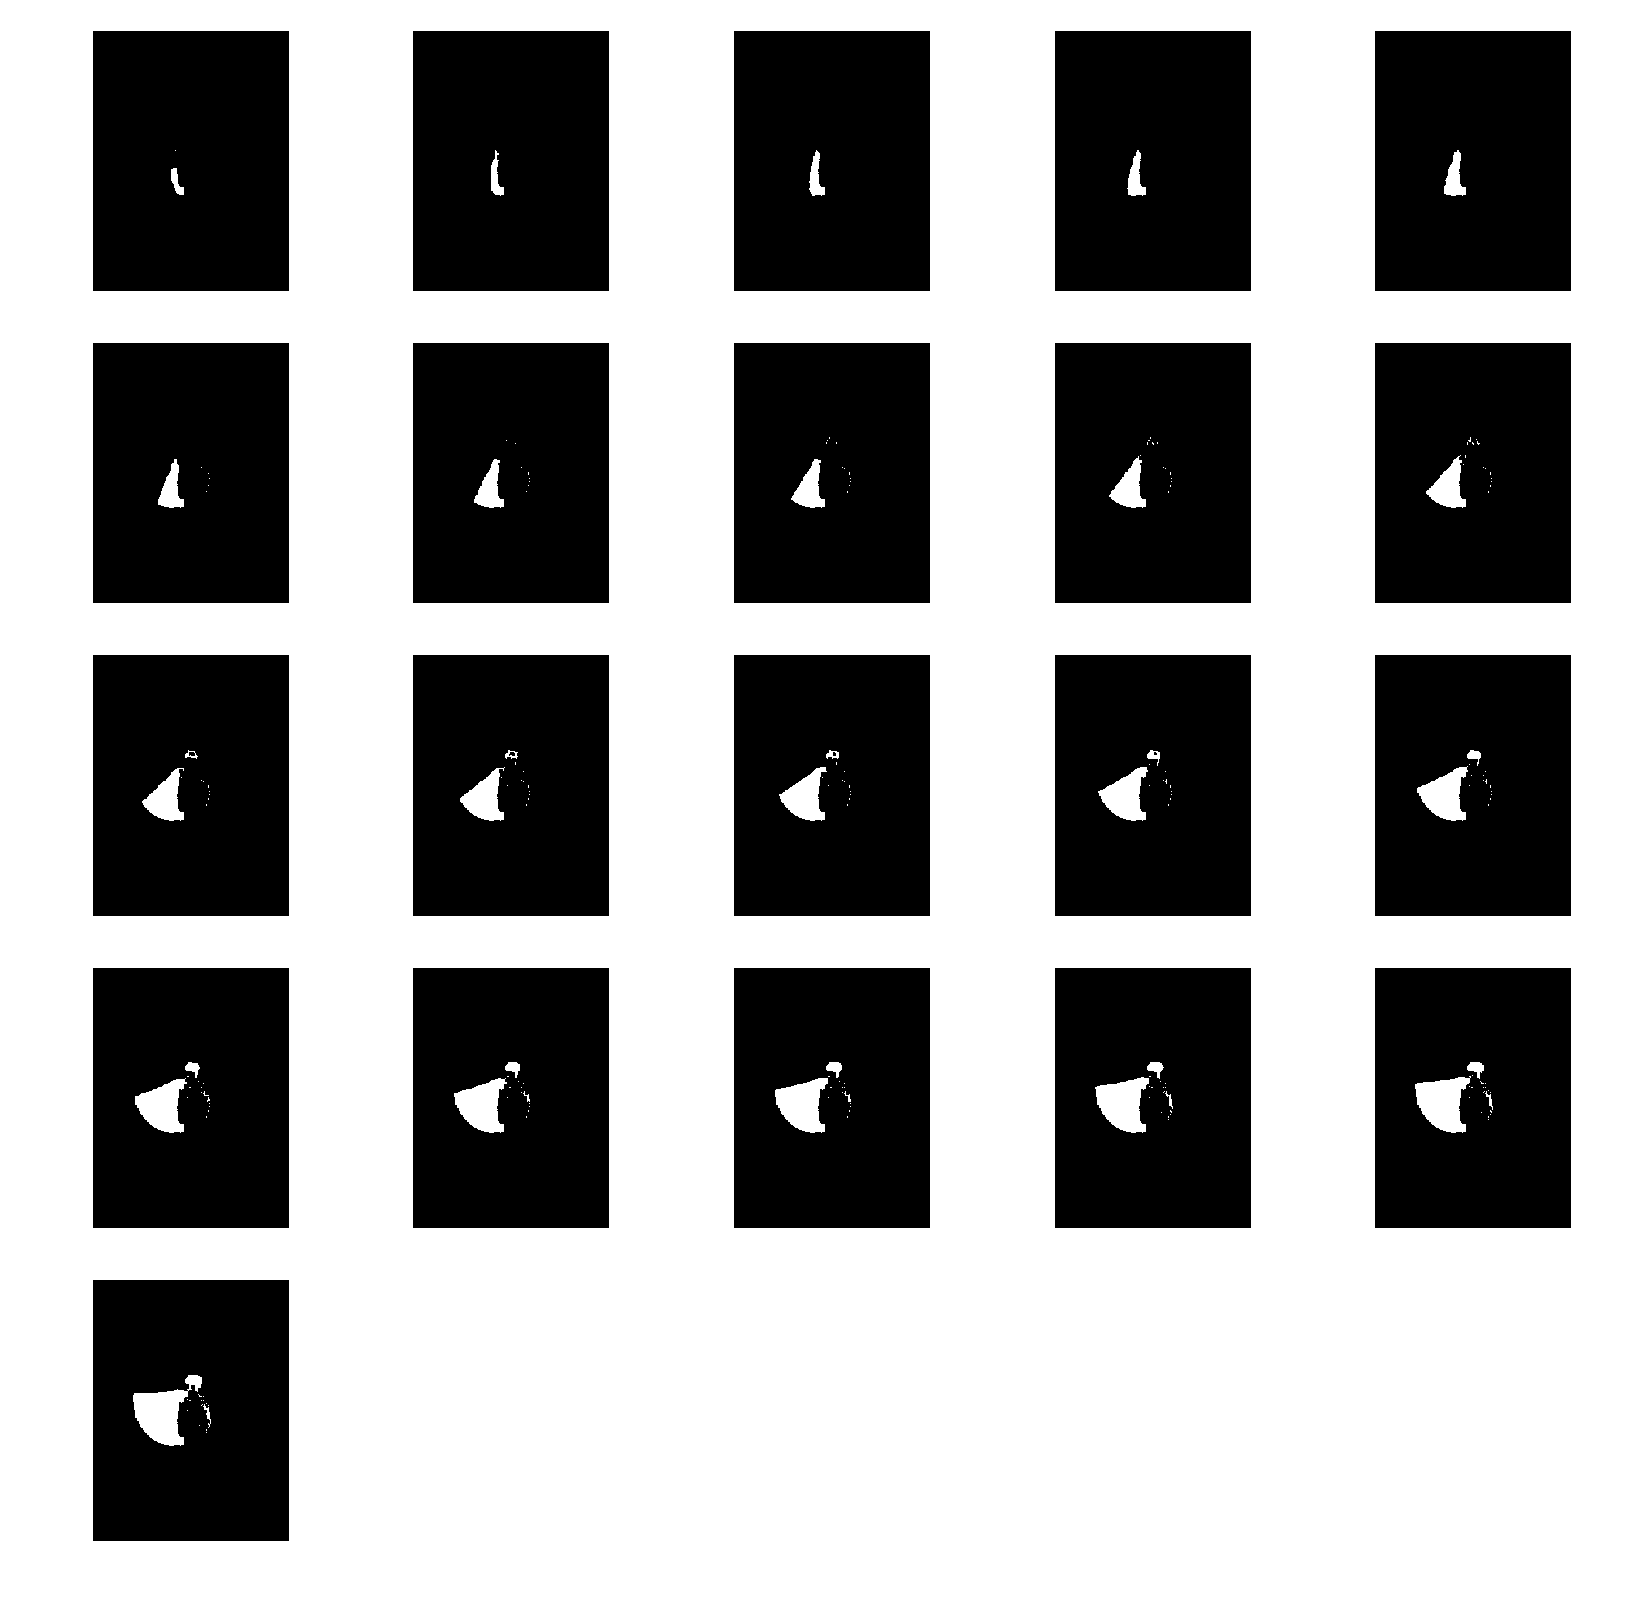

In [13]:
f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(MEI[idx], cmap = 'gray')
    
for idx in range(21, 25):
    axarr[idx//5, idx%5].axis('off')

We can see that MEI imaging produces a chunky representation of the motion

In [14]:
MHI = np.zeros(aer_cube.shape)

for idx in range(1, T-1):
    for i in range(0, aer_cube.shape[1]):
        for j in range(0, aer_cube.shape[2]):
            if aer_diff[idx][i][j] == 1:
                MHI[idx][i][j] = T
            else:
                MHI[idx][i][j] = max(0, MHI[idx-1][i][j] - 1)

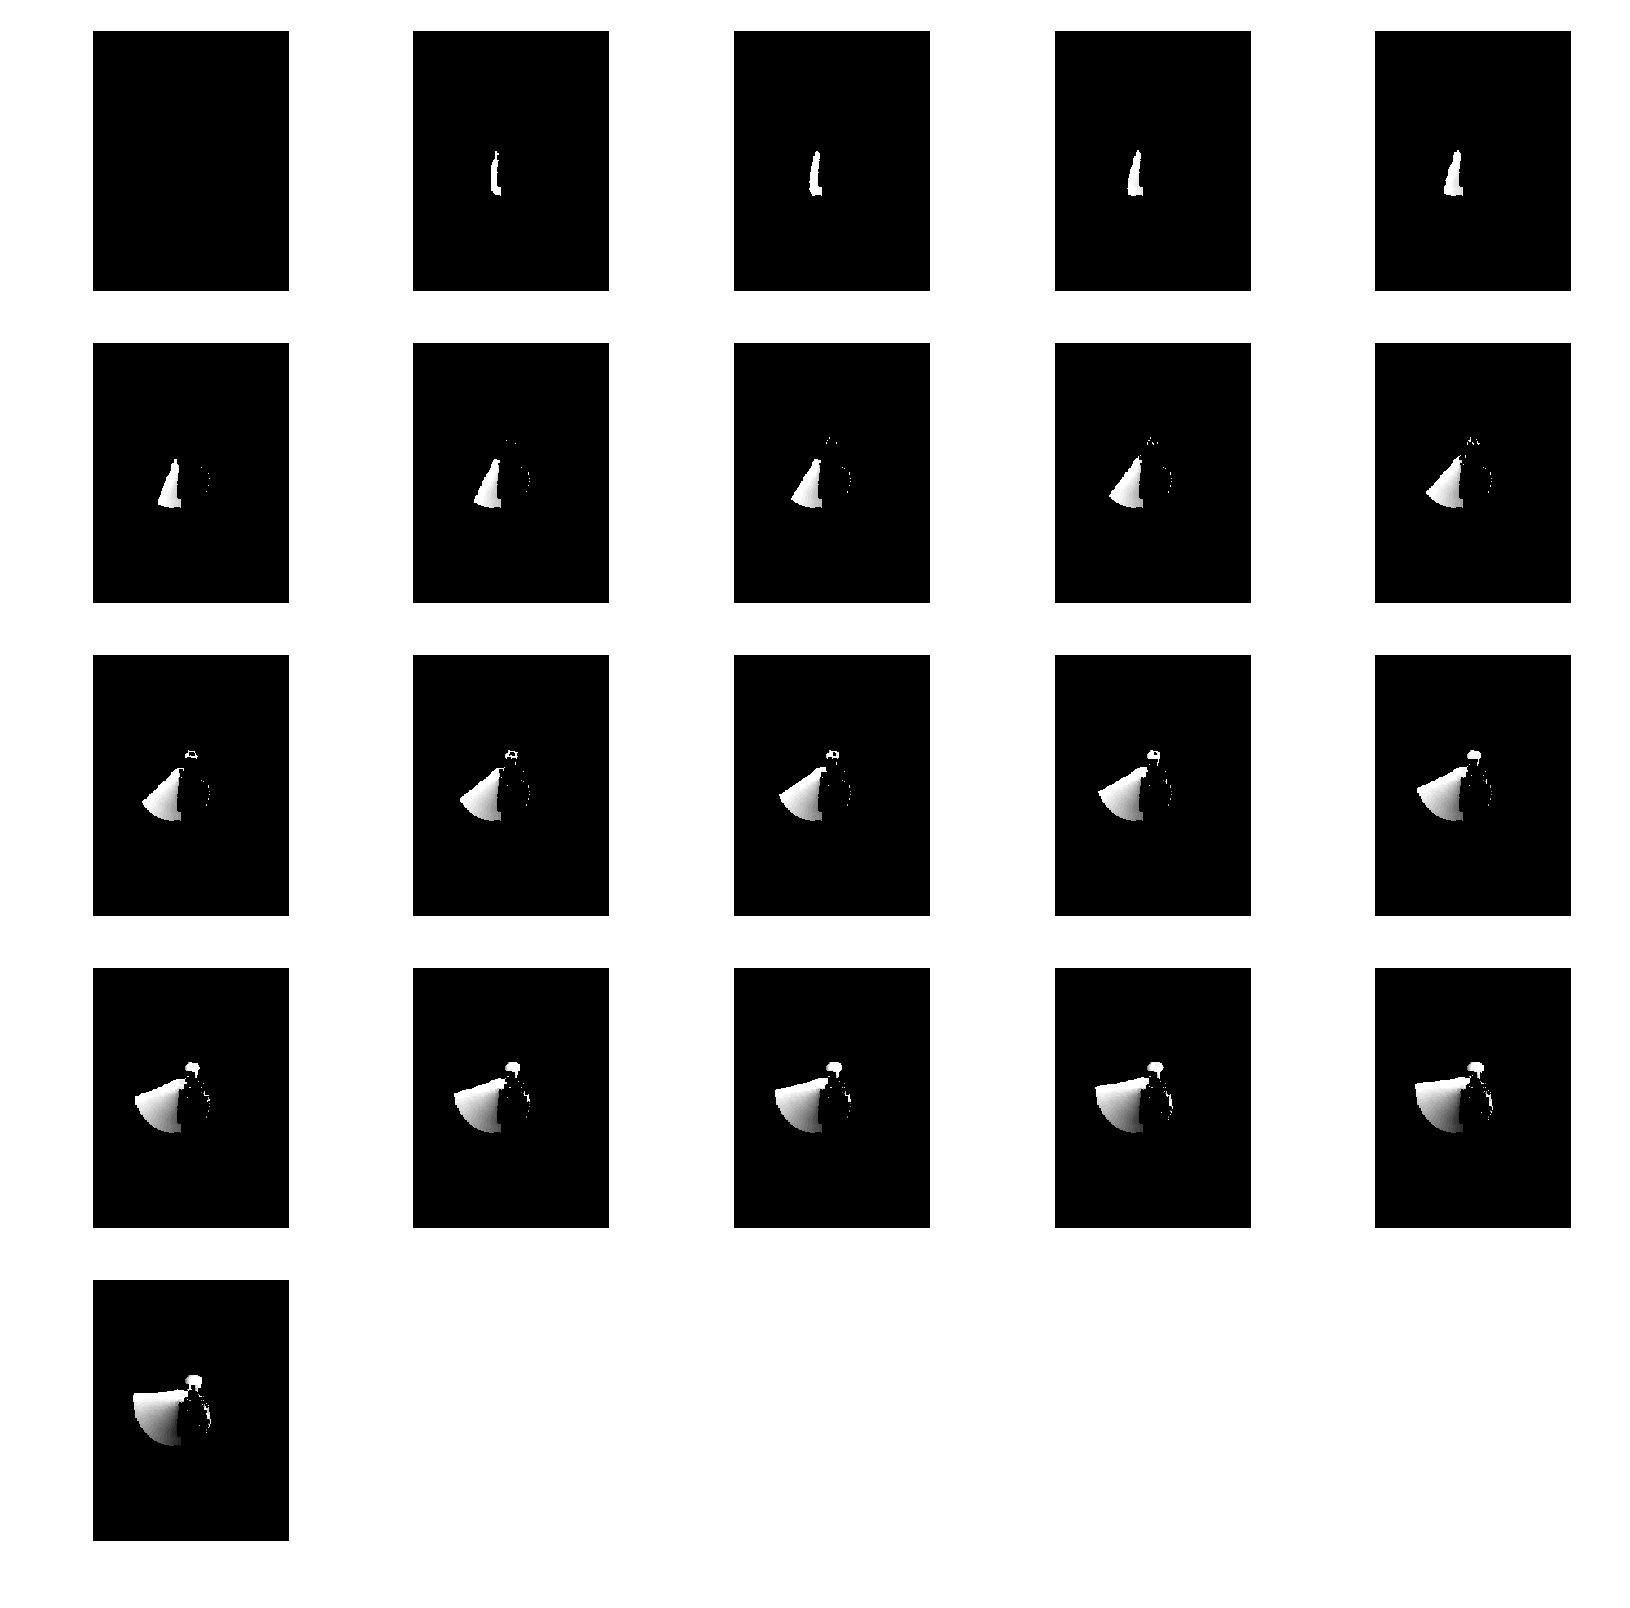

In [15]:
f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(MHI[idx], cmap = 'gray')
    
for idx in range(21, 25):
    axarr[idx//5, idx%5].axis('off')

The MHI imaging we can see produces a smoother texture which better captures the direction of the movement. MEI would result in the same image if the hand was being raised or lowered while MHI would generate opposite textures, thus making it more useful.

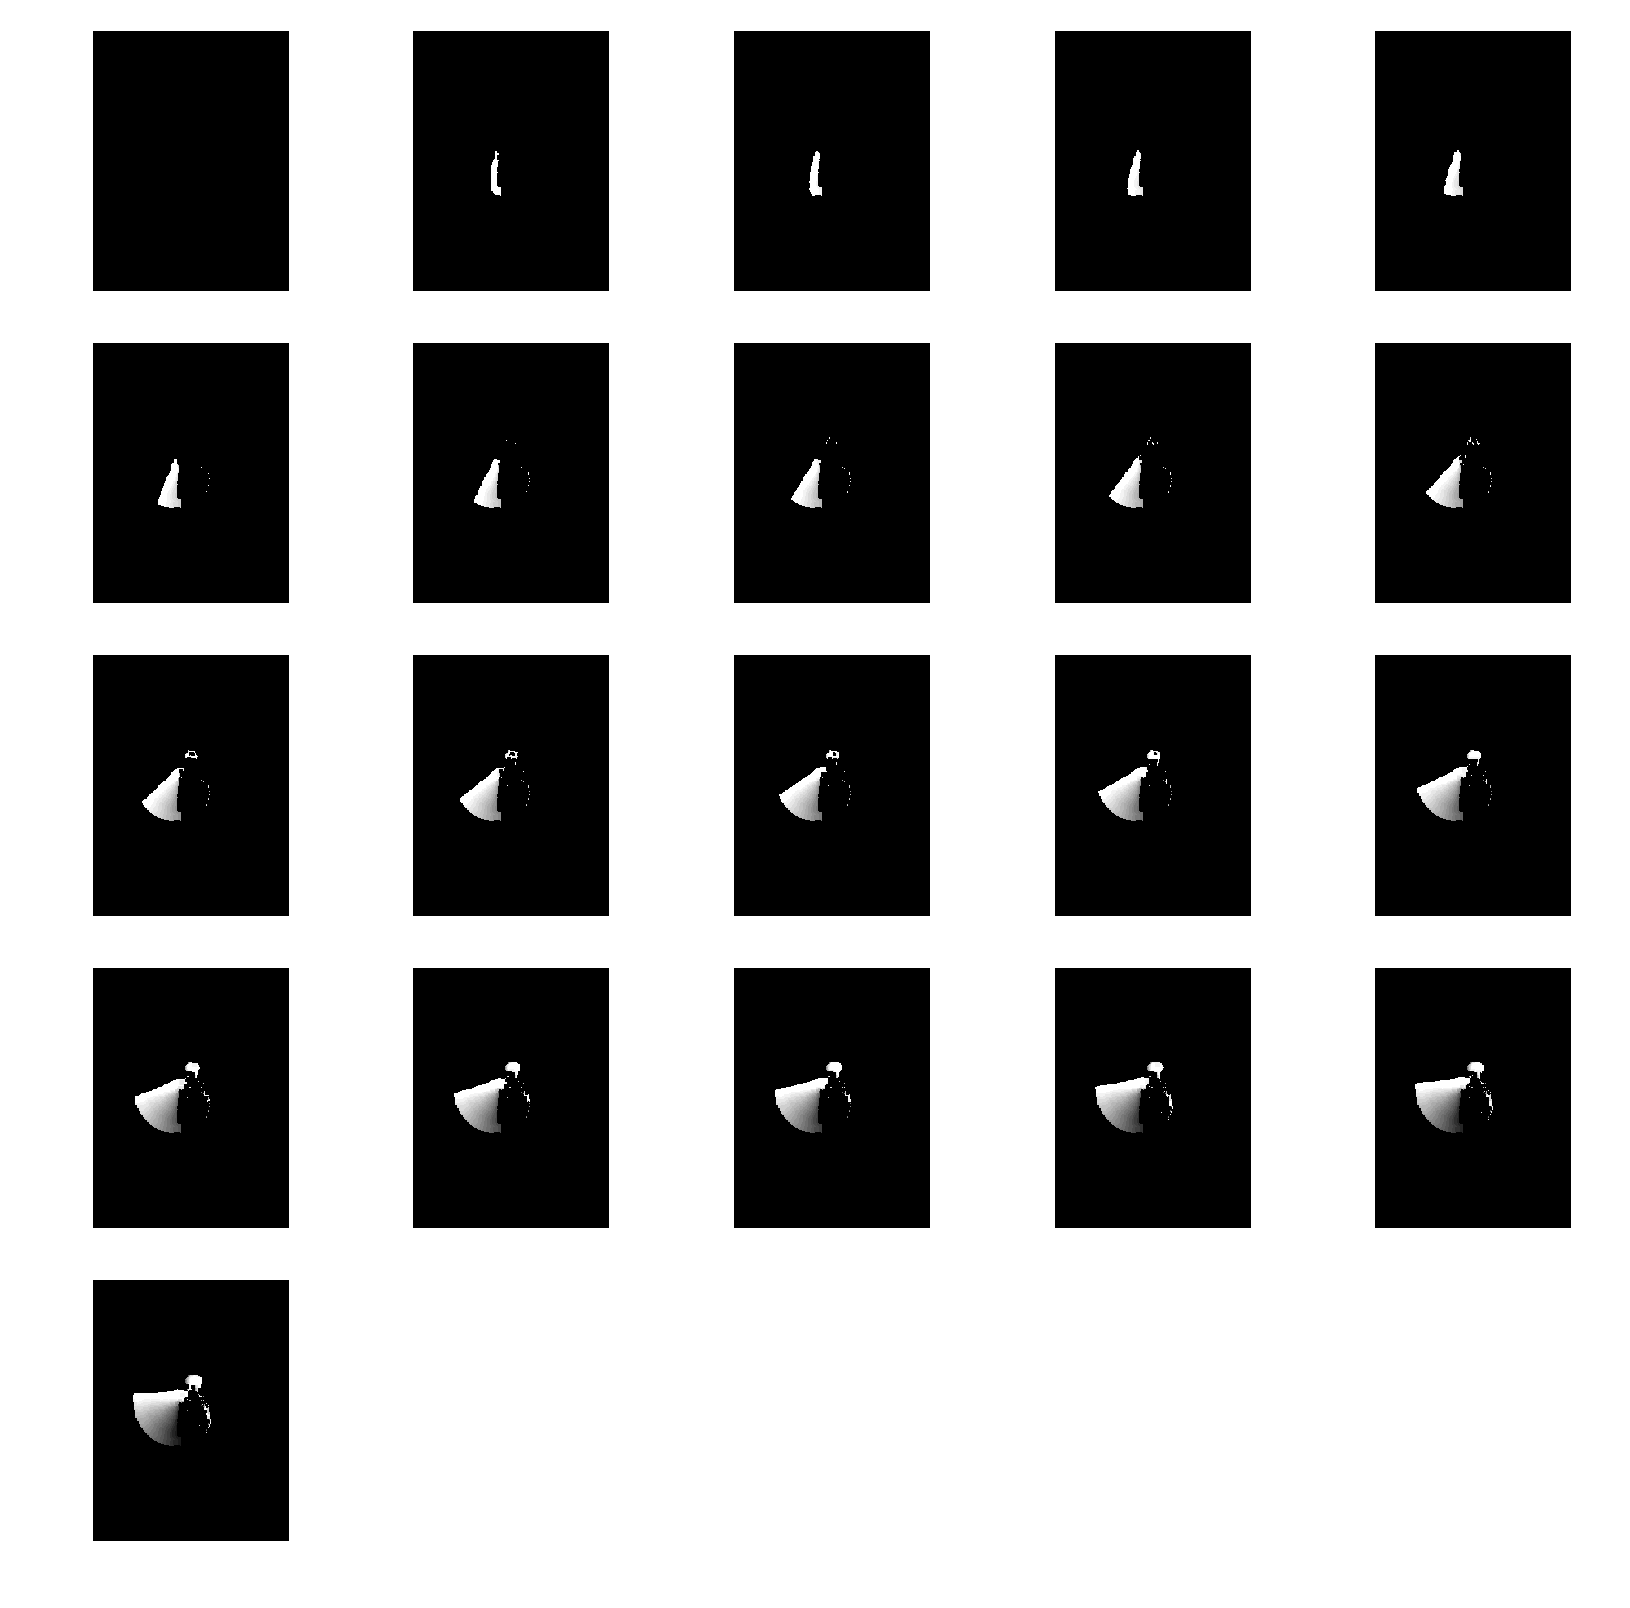

In [16]:
delta_T = (T-15)/(8)

MHI_deltaT = np.zeros(MHI.shape)

for idx in range(1, T-1):
    for i in range(0, aer_cube.shape[1]):
        for j in range(0, aer_cube.shape[2]):
            if MHI[idx][i][j] - delta_T > 0:
                MHI_deltaT[idx][i][j] = MHI[idx][i][j] - delta_T

f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(MHI_deltaT[idx], cmap = 'gray')
    
for idx in range(21, 25):
    axarr[idx//5, idx%5].axis('off')

This is the implementation of MHI but with $\tau - \Delta\tau$

## Similtude Moments for the last MHI and MEI

In [17]:
from numpy import mgrid, sum


def similitudeMoments(image):
    
    ### Make sure the image is a grayscale image
    assert len(image.shape) == 2
    
    ## Temp grid for storing intermediate operations
    x, y = mgrid[:image.shape[0],:image.shape[1]]
    
    ## Our final dictionary that contains the 
    moments = {}
    
    
    moments['mean_x'] = sum(x*image)/sum(image)
    moments['mean_y'] = sum(y*image)/sum(image)
    
    ## Spatial moments: Spatial moments  often used to describe region shape
    
    # Zeroth Order
    moments['m00'] = sum(image)
    
    # First Order
    moments['m01'] = sum(x*image)
    moments['m10'] = sum(y*image)
    
    # Second Order
    moments['m11'] = sum(y*x*image)
    moments['m02'] = sum(x**2*image)
    moments['m20'] = sum(y**2*image)
    
    # Third Order
    moments['m12'] = sum(x*y**2*image)
    moments['m21'] = sum(x**2*y*image)
    moments['m03'] = sum(x**3*image)
    moments['m30'] = sum(y**3*image)
    
    ## Central moments: Translation Invariant
    
    # First Order (Seem useless, in terms of calculating the final nu moments. But still kept)
    moments['mu01']= sum((y-moments['mean_y'])*image)
    moments['mu10']= sum((x-moments['mean_x'])*image)
    
    # Second Order (Moment Ellipse Orientation)
    moments['mu11'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])*image)
    moments['mu02'] = sum((y-moments['mean_y'])**2*image)
    moments['mu20'] = sum((x-moments['mean_x'])**2*image)
    
    # Third Order (Skewness of the Image)
    moments['mu12'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])**2*image)
    moments['mu21'] = sum((x-moments['mean_x'])**2*(y-moments['mean_y'])*image)
    moments['mu03'] = sum((y-moments['mean_y'])**3*image)
    moments['mu30'] = sum((x-moments['mean_x'])**3*image)
    
    # Similitude Moments: Invariant to translation and scale
    
    moments['eta11'] = moments['mu11'] / sum(image)**(2/2+1)
    moments['eta12'] = moments['mu12'] / sum(image)**(3/2+1)
    moments['eta21'] = moments['mu21'] / sum(image)**(3/2+1)
    moments['eta02'] = moments['mu02'] / sum(image)**(2/2+1)
    moments['eta20'] = moments['mu20'] / sum(image)**(2/2+1)
    moments['eta03'] = moments['mu03'] / sum(image)**(3/2+1)
    moments['eta30'] = moments['mu30'] / sum(image)**(3/2+1)
    
    return moments

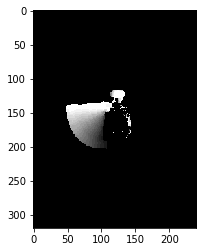

In [18]:
lastMHI = MHI_deltaT[-2]
lastMHI = lastMHI/T

plt.imshow(lastMHI, cmap='gray')

In [19]:
lastMHI_moments = similitudeMoments(lastMHI)
print(lastMHI_moments)

{'mean_x': 154.03915051895743, 'mean_y': 86.05553257989888, 'm00': 2266.8920454545455, 'm01': 349190.125, 'm10': 195078.60227272726, 'm11': 29705127.90340909, 'm02': 54553827.30681817, 'm20': 18033560.238636363, 'm12': 2710335140.607955, 'm21': 4595268018.482954, 'm03': 8643881351.704546, 'm30': 1782693918.6022725, 'mu01': 2.091837814077735e-11, 'mu10': -9.094947017729282e-12, 'mu11': -344614.2751073751, 'mu02': 1245967.225114544, 'mu20': 764877.0822096244, 'mu12': -8227229.426036114, 'mu21': 6777535.711377485, 'mu03': 16361541.68607024, 'mu30': 4814103.814391278, 'eta11': -0.06706124106216878, 'eta12': -0.03362610091249923, 'eta21': 0.027700953500533403, 'eta02': 0.2424627024313879, 'eta20': 0.14884353347523346, 'eta03': 0.06687243339522808, 'eta30': 0.019676069826578574}


We can see that as a consequence of being smoother textured, the moments reflect this in their means, where the mean is lower than the one for MEI, reflecting the change in perceived center of attention.

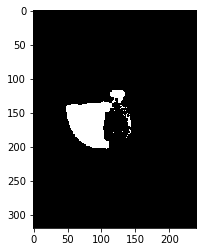

In [20]:
lastMEI = MEI[-1]
lastMEI_normalized = np.zeros(lastMEI.shape)
for i in range(lastMEI.shape[0]):
    for j in range(lastMEI.shape[1]):
        t = (lastMEI[i][j]*(20. - 1.)/21.)
        if t > 0:
            lastMEI_normalized[i][j] = t

plt.imshow(lastMEI_normalized, cmap='gray')

In [21]:
lastMEI_moments = similitudeMoments(lastMEI_normalized)
print(lastMEI_moments)

{'mean_x': 161.99532324621734, 'mean_y': 86.74140302613479, 'm00': 3288.809523809524, 'm01': 532771.7619047619, 'm10': 285275.95238095237, 'm11': 45932242.142857134, 'm02': 87706841.85714287, 'm20': 26192081.76190476, 'm12': 4179727007.095238, 'm21': 7530974327.285713, 'm03': 14661736276.333332, 'm30': 2537229224.5238094, 'mu01': 3.3651303965598345e-11, 'mu10': -2.546585164964199e-11, 'mu11': -281127.97746774094, 'mu02': 1446845.4027641318, 'mu20': 1400308.0709242157, 'mu12': -14496874.024974491, 'mu21': 14242644.772700459, 'mu03': 14288503.925605964, 'mu30': -48638.40669892728, 'eta11': -0.025991217607318155, 'eta12': -0.023371014316687883, 'eta21': 0.022961160752093104, 'eta02': 0.13376567514240228, 'eta20': 0.1294631438553694, 'eta03': 0.023035092202229136, 'eta30': -7.841200091435006e-05}


Also notice that other features are largely similar since the shape itself resembles the one generated by MHI.

# Perform Optic Flow on the set of images using the best differencing technique

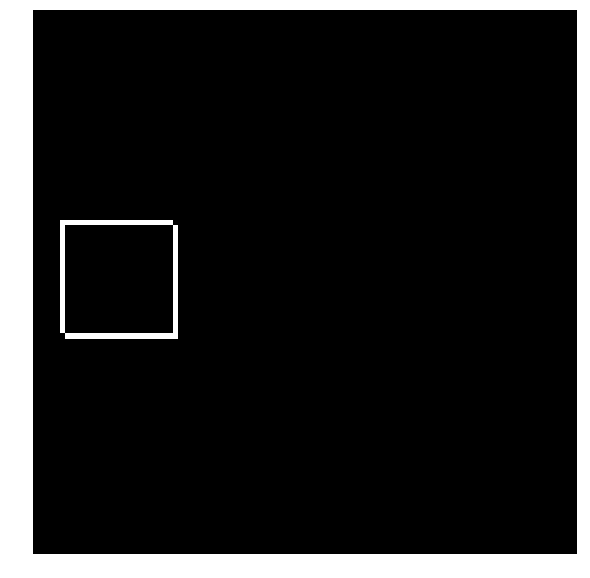

In [22]:
box1 = np.zeros((101,101))
box2 = np.zeros((101,101))

size = 21
box1[39:39+size, 5:5+size] = 1
box2[40:40+size, 6:6+size] = 1

box1 = img_as_float(box1)
box2 = img_as_float(box2)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(np.abs(box2-box1), cmap='gray')

Just a plot of image diff, to show that it is indeed shifted by just 1 pixel down and right.

In [23]:
from scipy import signal
def optical_flow(I1g, I2g, window_size):
 
    kernel_x = 0.25 * np.array([[-1., 1.], [-1., 1.]])
    kernel_y = 0.25 * np.array([[-1., -1.], [1., 1.]])
    kernel_t = 0.25 * np.array([[1., 1.], [1., 1.]])
    kernel_x = np.fliplr(kernel_x)
    mode = 'same'
    fx = (signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode))
    fy = (signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode))
    ft = (signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + 
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode))
    
    #ft = I2g - I1g
    
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    window = np.ones((window_size,window_size))
    
    denom = (signal.convolve2d(fx**2, window, boundary='symm', mode=mode) * 
            signal.convolve2d(fy**2, window, boundary='symm', mode=mode) -
            signal.convolve2d(fx*fy, window, boundary='symm', mode=mode)**2)
    denom[denom == 0] = 1
    
    u = ((signal.convolve2d(fy**2, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode) + 
             signal.convolve2d(fx*fy, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode) ) /
        denom)
    
    
    v = ((signal.convolve2d(fx*ft, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fx*fy, window, boundary='symm', mode=mode) -
             signal.convolve2d(fx**2, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode)) / 
        denom)
    
 
    return (u,v)

u,v = optical_flow(box1, box2, 3)

The optical flow calculation function. Notice that I use convolution to calculate the vectors. There might be easier ways to do it, and even ways to do it that's computationally a lot cheaper, but in-order to preserve the scales when plotting and make sure the formula used is a direct translation of the ones present in slides, I decided to go with this approach.

In [24]:
x = np.arange(0, box1.shape[1], 1)
y = np.arange(0, box1.shape[0], 1)
x, y = np.meshgrid(x, y)
delta = 3

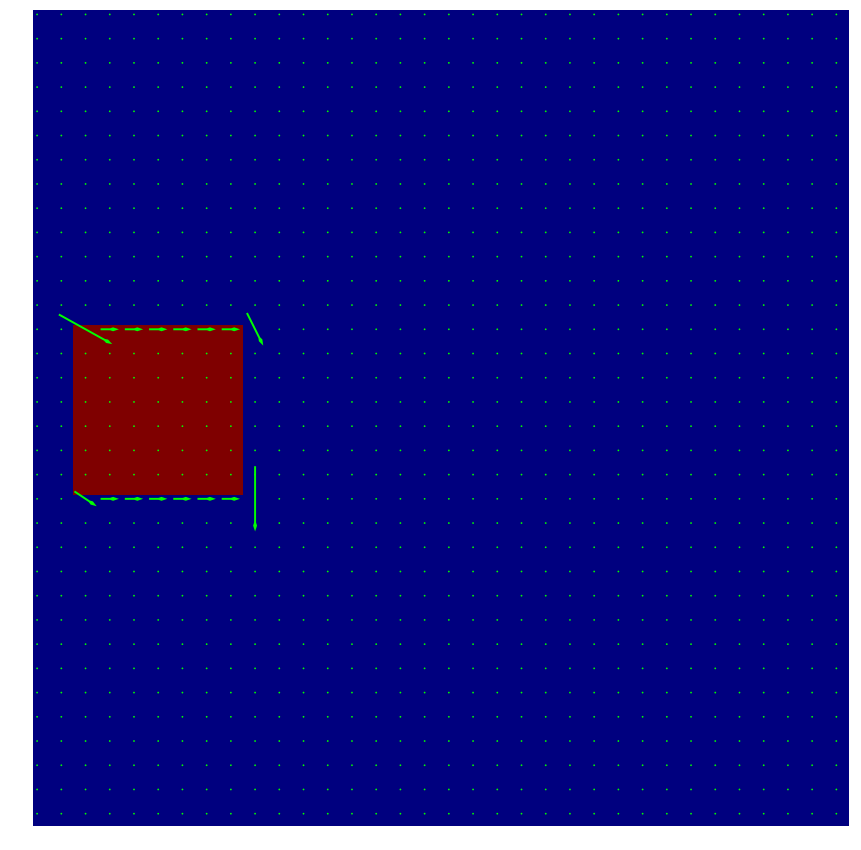

In [25]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(box1, cmap='jet')
plt.quiver(x[::delta, ::delta], y[::delta, ::delta],
           u[::delta, ::delta], v[::delta, ::delta],
color='lime', pivot='middle', headwidth=2, headlength=3, scale=25)

Notice that the arrows are pointed in the direction of motion.